In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import pandas as pd
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler1=StandardScaler()
scaler2= MinMaxScaler()
from sklearn.metrics import mean_squared_error,mean_absolute_error,max_error,r2_score, explained_variance_score,mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit

In [2]:
# Load the data
df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)

# Split the data into train and test sets
train = df[df['Month'] <= 10]
test = df[df['Month'] > 10]

# Define the features and target
X_train = train[['Temperature','Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_train = np.sqrt(train['PowerConsumption_Zone1'])
X_test = test[['Temperature','Holiday',  'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_test = np.sqrt(test['PowerConsumption_Zone1'])



In [3]:
tscv = TimeSeriesSplit( max_train_size=4320*3, n_splits=8,test_size=4320)# 144 samples per day * 30 days = 4320 samples


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# Define the pipeline with Recursive Feature Elimination and SelectKBest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression, k=5)),
    ('lgbm', LGBMRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.01],
    'lgbm__max_depth': [3, 5],
    'lgbm__colsample_bytree': [0.8, 1.0]
}



In [6]:
# Perform grid search using GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv )
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_


In [7]:
# Access the SelectKBest object from the pipeline
select_kbest = best_model.named_steps['feature_selection']

# Get the selected features using get_support() method
selected_features = X_train.columns[select_kbest.get_support()].tolist()

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the selected features
print("Selected Features:", selected_features)


Mean Squared Error: 127.9134556339619
Selected Features: ['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour']


In [8]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 200}


In [9]:

# Make predictions with the best model
y_pred = best_model.predict(X_test)


In [10]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 127.9134556339619
MAE: 10.234095812416685
R-squared: 0.5919613884308982


## residual plot

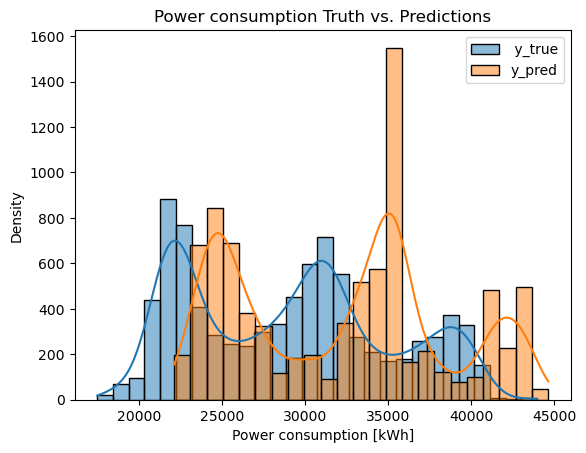

In [7]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

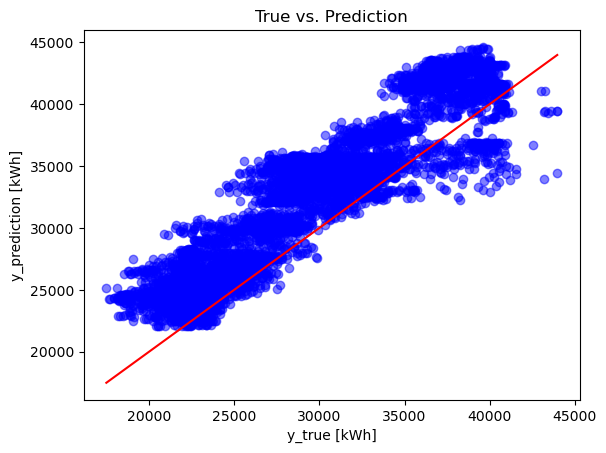

In [8]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

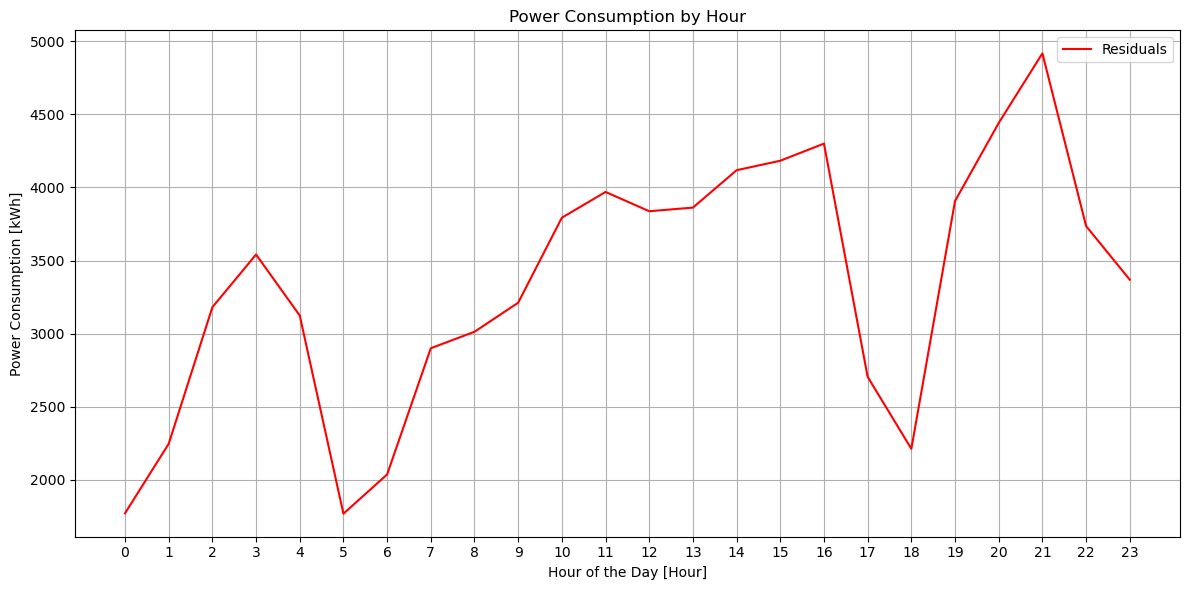

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


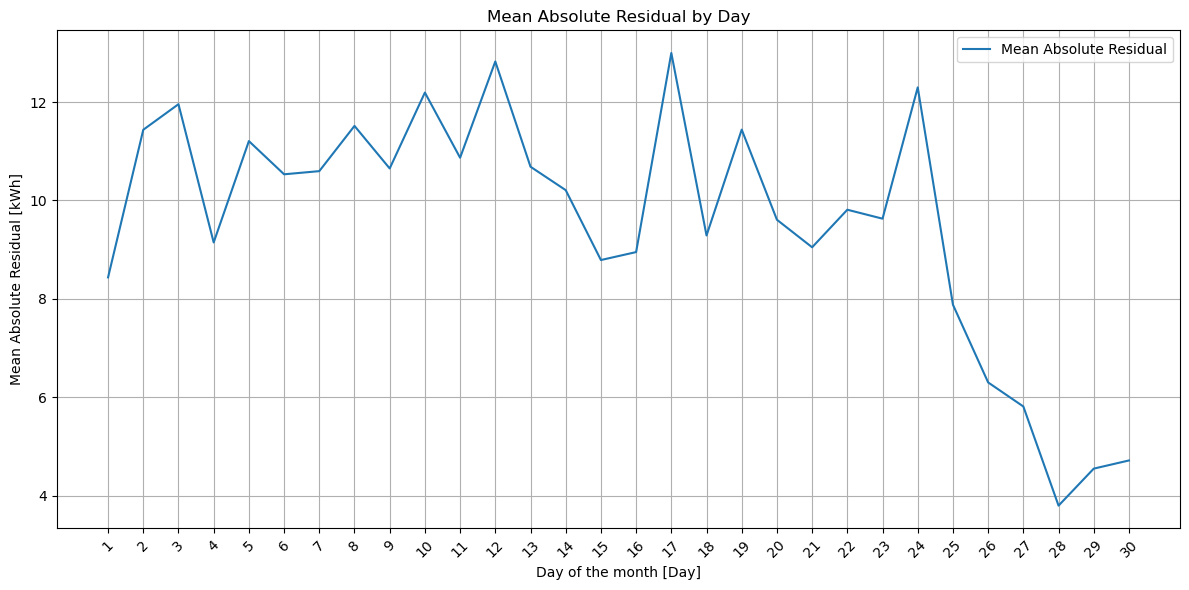

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = y_pred - y_test

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## min max scaler

In [11]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lgbm', LGBMRegressor())
])

# Define the parameter grid for grid search
param_grid = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.1, 0.01],
    'lgbm__max_depth': [3, 5],
    'lgbm__colsample_bytree': [0.8, 1.0]  # Include colsample_bytree parameter here
}


In [12]:
# Perform grid search using GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv )
grid_result = grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_


In [13]:

# Make predictions with the best model
y_pred = best_model.predict(X_test)


In [14]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 121.42747411000056
MAE: 9.803998239518412
R-squared: 0.6126514001468928


## residual plot

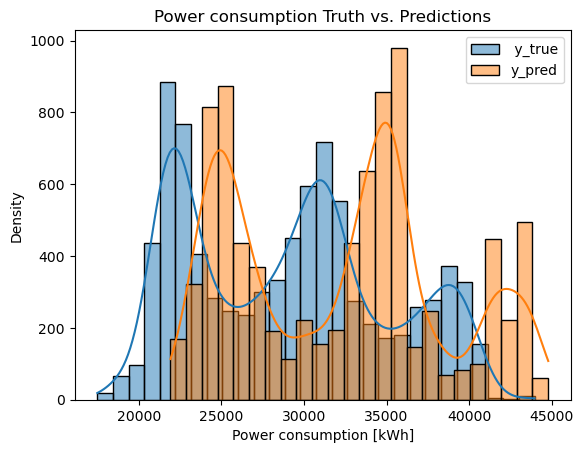

In [15]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

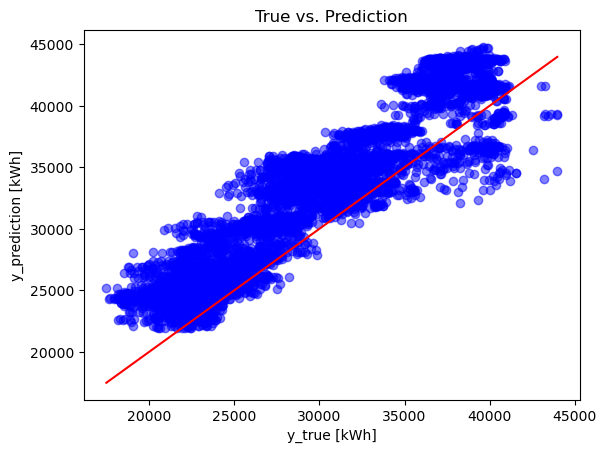

In [16]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

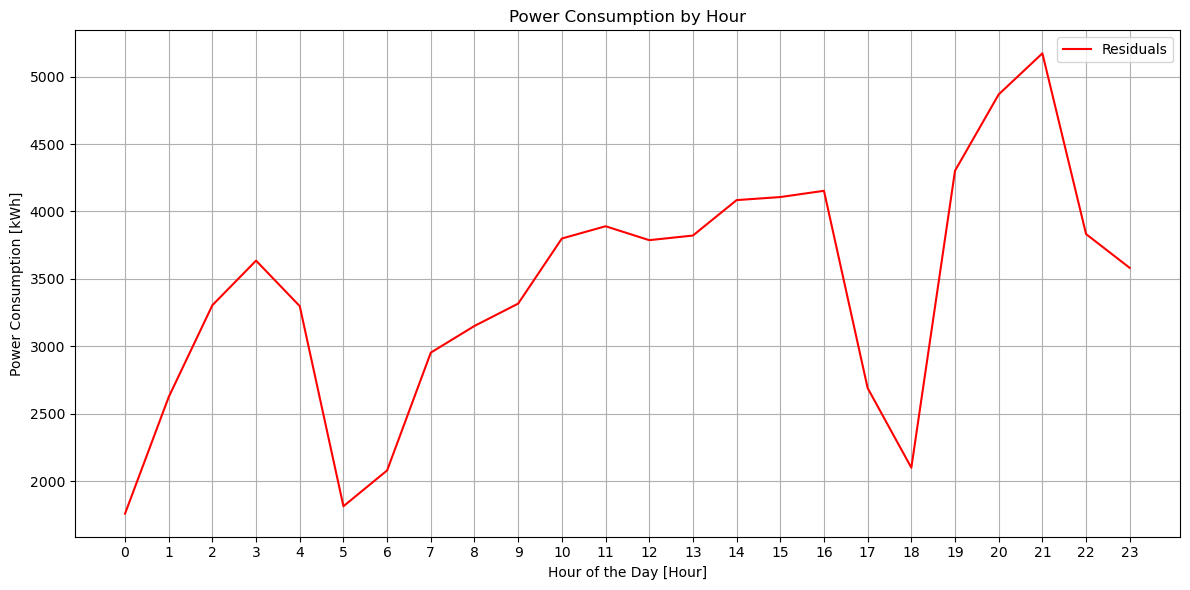

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


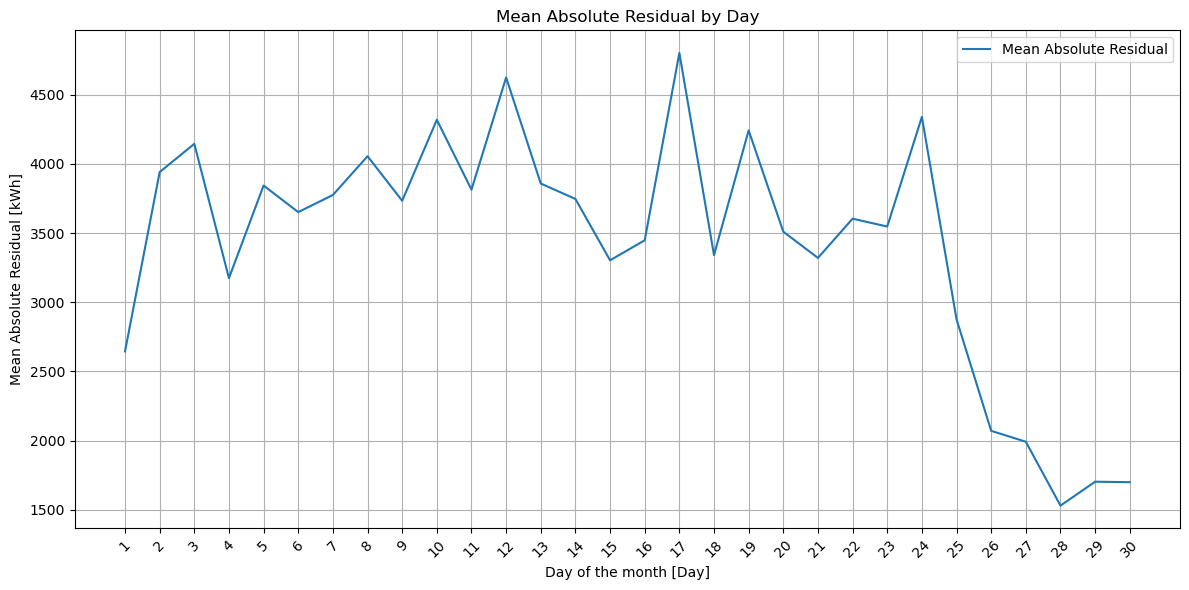

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
